In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, sqrt, atan2
import numpy as np
import osmnx as ox
from pyscipopt import Model, quicksum

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))

In [3]:
city_data = pd.read_csv('eras_cities.csv')

In [ ]:
# define the dataset (cities)
cities = city_data[:15].reset_index(drop=True) # US_cities, cities_all, european_cities
number_cities = len(cities)
city_names = list(cities['city'])

# define start city
start_city = 0  

# calculate distances between the cities
dist = {(i, j): haversine(cities.loc[i, 'lat'], cities.loc[i, 'lon'], cities.loc[j, 'lat'], cities.loc[j, 'lon']) for i in range(number_cities) for j in range(number_cities) if i != j}

# Create model
model = Model("TSP_Tour")

# Decision variables:  x[i,j] = 1 if there's a path from city i to city j; else 0
x = {}
for (i, j) in dist:
    x[i, j] = model.addVar(vtype="B", name=f"x({i},{j})") # binary

# subtour elimination (MTZ)
u = {} # saves the position of each city in the route
for i in range(number_cities):
    if i != start_city:
        u[i] = model.addVar(vtype="I", lb=1, ub=number_cities - 1, name=f"u({i})")

# objective function: minimize total distances
model.setObjective(quicksum(dist[i, j] * x[i, j] for (i, j) in dist), "minimize")

# constraints
# each city is left exactly once
for i in range(number_cities):
    model.addCons(quicksum(x[i, j] for j in range(number_cities) if i != j) == 1)

# each city is entered exactly once
for j in range(number_cities):
    model.addCons(quicksum(x[i, j] for i in range(number_cities) if i != j) == 1)
    
# subtour elimination (MTZ)
for i in range(number_cities):
    for j in range(number_cities):
        if i != j and i != start_city and j != start_city:
            model.addCons(u[i] - u[j] + number_cities * x[i, j] <= number_cities - 1)

# solve model
model.optimize()

print("Optimal distance:", model.getObjVal())

# save route
edges = [(i, j) for (i, j) in dist if model.getVal(x[i, j]) == 1]
route = [0]
while len(route) < number_cities:
    for (i, j) in edges:
        if i == route[-1]:
            route.append(j)
            break
route.append(route[0])

print("Route:")
print(" → ".join([city_names[i] for i in route]))

Optimal distance: 7027.5395035169495
Route:
Glendale → Houston → Tampa → Arlington → Paradise → Glendale
presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 12 chg sides, 12 chg coeffs, 0 upgd conss, 0 impls, 10 clqs
(round 2, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 12 chg sides, 12 chg coeffs, 10 upgd conss, 0 impls, 10 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 12 changed sides, 12 changed coefficients
 24 implications, 10 cliques
presolved problem has 24 variables (20 bin, 4 int, 0 impl, 0 cont) and 22 constraints
     10 constraints of type <setppc>
     12 constraints of type <linear>
Presolving Time: 0.00



presolving:
Optimal distance: 10595.44684097115
Route:
Glendale → Paradise → Minneapolis → Chicago → Detroit → Foxborough → East Rutherford → Philadelphia → Pittsburgh → Cincinnati → Nashville → Atlanta → Tampa → Houston → Arlington → Glendale
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 182 chg sides, 182 chg coeffs, 0 upgd conss, 0 impls, 30 clqs
(round 2, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 182 chg sides, 182 chg coeffs, 30 upgd conss, 0 impls, 30 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 182 changed sides, 182 changed coefficients
 364 implications, 30 cliques
presolved problem has 224 variables (210 bin, 14 

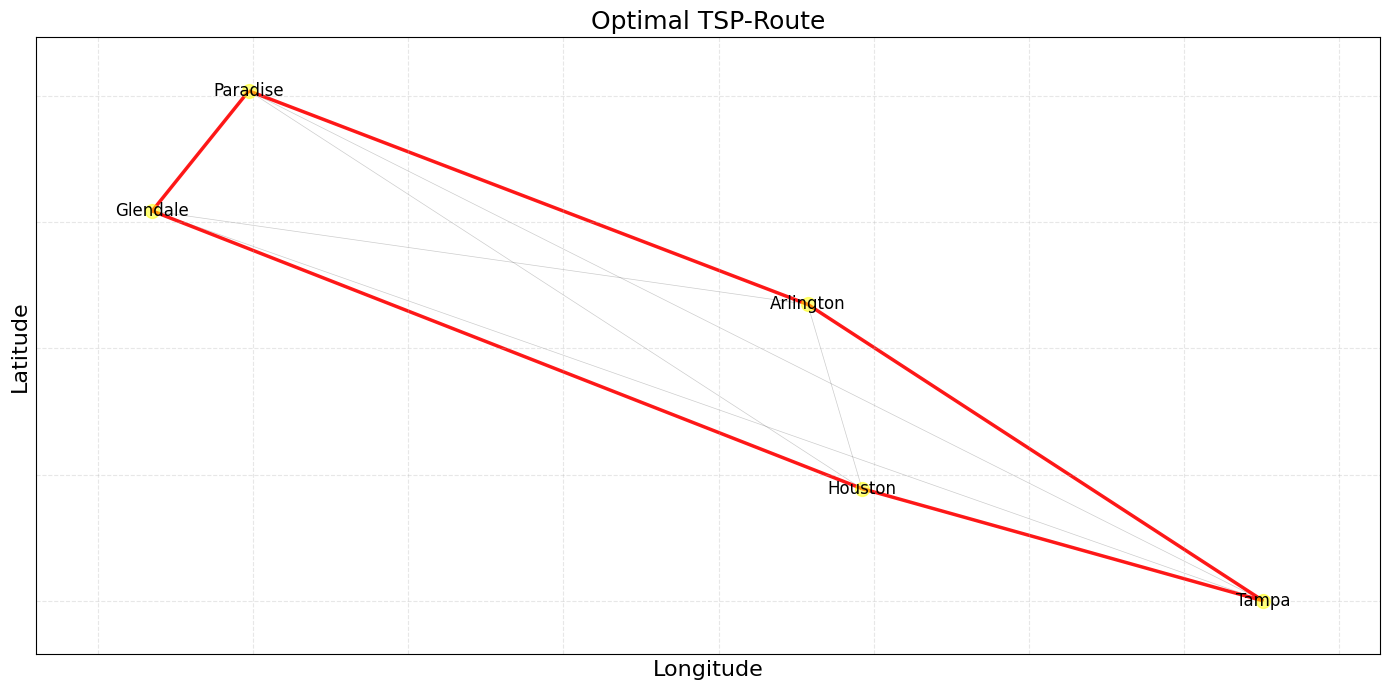

In [ ]:
# plot
Graph = nx.Graph()

for _, row in cities.iterrows():
    Graph.add_node(row.city, pos=(row.lon, row.lat))

for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        dist = haversine(cities.lat[i], cities.lon[i], cities.lat[j], cities.lon[j])
        Graph.add_edge(cities.city[i], cities.city[j], weight=dist)

pos = nx.get_node_attributes(Graph, 'pos')

plt.figure(figsize=(14, 7))
nx.draw_networkx_edges(Graph, pos, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(Graph, pos, node_size=100, node_color="yellow", alpha=0.5)
nx.draw_networkx_labels(Graph, pos, font_size=12, font_color="black")

route_cities = [cities.city[i] for i in route]
route_edges = [(route_cities[i], route_cities[i+1]) for i in range(len(route_cities)-1)]

nx.draw_networkx_edges(Graph, pos, edgelist=route_edges, edge_color="red", width=2.5, alpha=0.9)

plt.title("Optimal TSP-Route", size=18)
plt.xlabel("Longitude", size=16)
plt.ylabel("Latitude", size=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()